In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pinocchio as pin
from pinocchio.utils import rotate
from robot_descriptions.loaders.pinocchio import load_robot_description
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import pink
from pink import solve_ik
from pink.tasks import FrameTask
import qpsolvers
import time
from tqdm import tqdm

from scripts.humanoid_mpc import MPCRobust, feet, foot, MPCForce


## Import robot

In [2]:
robot = load_robot_description(
        "jvrc_description", root_joint=pin.JointModelFreeFlyer()
    )
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz = MeshcatVisualizer(robot)
q0 = configuration.q.copy()
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


## MPC Control

In [144]:
viz.display(q0)

In [153]:
   
def get_parameters_robot(configuration):
    l_ankle_position = configuration.get_transform_frame_to_world("l_ankle").copy().translation
    r_ankle_position = configuration.get_transform_frame_to_world("r_ankle").copy().translation
    pelvis_position = configuration.get_transform_frame_to_world("root_joint").copy().translation
    
    leg_length = (pelvis_position - l_ankle_position)[-1]
    x_left_foot = l_ankle_position[0] * (-1)
    x_right_foot = r_ankle_position[0] * (-1)
    return leg_length, x_left_foot, x_right_foot    
    

In [154]:
leg_length, x_left_foot, x_right_foot = get_parameters_robot(configuration)
print(f'{leg_length}, {x_left_foot}, {x_right_foot}')

0.7460000000000002, 0.09599999999996901, -0.09600000000003167


In [227]:
T = 0.025
g = 9.87
N = 50
step_duration = 3.5
overlap = int (step_duration / T) // 3

#not working with x_left_foot and right yet

leg_length, x_left_foot, x_right_foot = get_parameters_robot(configuration)
h_ankle = 0.1
h_CoM = leg_length + h_ankle
foot_length = h_CoM * 0.28
foot_width = foot_length / 2
spread = foot_length * 1.1

robot_feet = feet(spread=spread, length=foot_length, width=foot_width, right=foot(x_right_foot, 0), left=foot(x_left_foot, 0))
 

mpc = MPCRobust(T, N, h_CoM, g, robot_feet, duration=21, 
                step_duration=step_duration,
                overlap=overlap
                )
Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')
Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord='y')
feet_tracker = mpc.feet_tracker

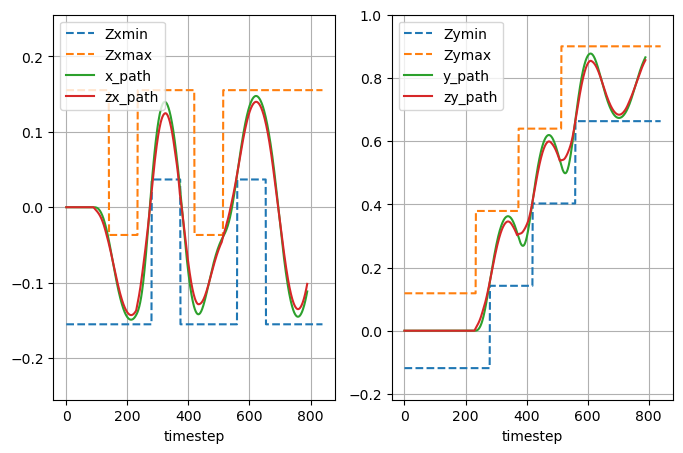

In [228]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].plot(Zxmin,'--', label= 'Zxmin')
ax[0].plot(Zxmax,'--', label="Zxmax")
ax[0].plot(x_path, label="x_path")
ax[0].plot(zx_path, label="zx_path")
ax[0].set_xlabel('timestep')
ax[0].set_ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)
ax[0].grid()
ax[0].legend()

ax[1].plot(Zymin,'--', label= 'Zymin')
ax[1].plot(Zymax,'--', label="Zymax")
ax[1].plot(y_path, label="y_path")
ax[1].plot(zy_path, label="zy_path")
ax[1].set_xlabel('timestep')
ax[1].set_ylim(min(Zymin)-0.1, max(Zymax)+0.1)
ax[1].grid()
plt.legend()

# Move robot

In [304]:

configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz.display(configuration.q)

In [305]:
root_task = FrameTask("root_joint", position_cost=1.0, orientation_cost=1.0)
left_ankle_task = FrameTask("l_ankle", position_cost=0.9, orientation_cost=1.0)
right_ankle_task = FrameTask("r_ankle", position_cost=0.9, orientation_cost=1.0)
root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
x_left_ankle = configuration.get_transform_frame_to_world("l_ankle").translation[1]
ankle_orientation = configuration.get_transform_frame_to_world("l_ankle").rotation[1]
x_right_ankle = configuration.get_transform_frame_to_world("r_ankle").translation[1]
root_pose.translation[2] = h_CoM
root_task.set_target(pin.SE3(rotate('z', np.pi/2), root_pose.translation))
velocity = solve_ik(configuration, [root_task], T, solver='daqp')
configuration.integrate_inplace(velocity, T)

viz.display(configuration.q)

### Create footprints

In [306]:
def draw_feet_footprints(foot_trajectory, foot_name):
    for i,(x,y) in enumerate(foot_trajectory):
        step_name = f'{foot_name}_feet_{i}'
        y+=0.045
        pos = np.array([-x,y,0])
        dims = [foot_width, foot_length, foot_length/10]
        color = 'red'
        viz.addBox(step_name, dims, color)
        placement = pin.SE3(np.eye(3), np.array(pos))
        viz.applyConfiguration(step_name, placement)

draw_feet_footprints(mpc.left_trajectory, 'left')
draw_feet_footprints(mpc.right_trajectory, 'right')


In [297]:
step_duration

3.5

In [299]:
n_steps

139.0

In [308]:
n_steps = step_duration // T
last_left_y = 0
last_right_y = 0
for i in tqdm(range(len(x_path))):

    root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
    root_pose.translation[0] = x_path[i]
    root_pose.translation[1] = y_path[i]

    root_task.set_target(root_pose)
     
    left_foot, right_foot = feet_tracker[i]
    
    z_x = zx_path[i]
    z_y = zy_path[i]
    left_foot_pose = configuration.get_transform_frame_to_world("l_ankle").copy()
    right_foot_pose = configuration.get_transform_frame_to_world("r_ankle").copy()
    left_foot_pose.translation[2] = h_ankle
    right_foot_pose.translation[2] = h_ankle

    if left_foot and not right_foot:
        left_foot_pose.translation[1] = z_y
        right_foot_pose.translation[1] = last_left_y
    if not left_foot and right_foot:
        right_foot_pose.translation[1] = z_y
        left_foot_pose.translation[1] = last_right_y
        #right_foot_pose.rotation = np.eye(3)
    if left_foot and right_foot:
        # I am not sure if this part is correct
        #print(f'both, {z_x}, {z_y}')
        pass
        
    left_ankle_task.set_target(left_foot_pose)
    right_ankle_task.set_target(right_foot_pose)
    if i % n_steps == 0:
        print(f'New step at {i}')
        print(f'l:{left_foot}: {last_left_y}, r:{left_foot}: {last_left_y}')
        if left_foot:
            last_left_y = z_y
        if right_foot:
            last_right_y = z_y
        print(f'l:{left_foot}: {last_left_y}, r:{left_foot}: {last_left_y}')
    
    velocity = solve_ik(configuration, [root_task, left_ankle_task, right_ankle_task], T, solver='daqp')
    configuration.integrate_inplace(velocity, T)
    viz.display(configuration.q)
    time.sleep(T)


  0%|          | 1/790 [00:00<01:27,  8.97it/s]

New step at 0


 18%|█▊        | 140/790 [00:18<02:08,  5.07it/s]

New step at 139


 24%|██▎       | 187/790 [00:27<01:30,  6.70it/s]


KeyboardInterrupt: 